
Number of Clusters: 2
Davies-Bouldin Index: 0.9637
Silhouette Score: 0.3743
Inertia: 117.4809
Calinski-Harabasz Index: 84.7222

Number of Clusters: 3
Davies-Bouldin Index: 0.8353
Silhouette Score: 0.5753
Inertia: 63.7217
Calinski-Harabasz Index: 160.8050

Number of Clusters: 4
Davies-Bouldin Index: 0.3915
Silhouette Score: 0.7444
Inertia: 18.1855
Calinski-Harabasz Index: 537.3240

Number of Clusters: 5
Davies-Bouldin Index: 0.6265
Silhouette Score: 0.6441
Inertia: 16.4319
Calinski-Harabasz Index: 448.9294

Number of Clusters: 6
Davies-Bouldin Index: 0.7673
Silhouette Score: 0.5368
Inertia: 14.2596
Calinski-Harabasz Index: 417.6444

Number of Clusters: 7
Davies-Bouldin Index: 0.7989
Silhouette Score: 0.4883
Inertia: 11.4021
Calinski-Harabasz Index: 441.0768

Number of Clusters: 8
Davies-Bouldin Index: 0.8901
Silhouette Score: 0.4124
Inertia: 9.3450
Calinski-Harabasz Index: 464.9375

Number of Clusters: 9
Davies-Bouldin Index: 0.9747
Silhouette Score: 0.3838
Inertia: 8.9454
Calinski-Har

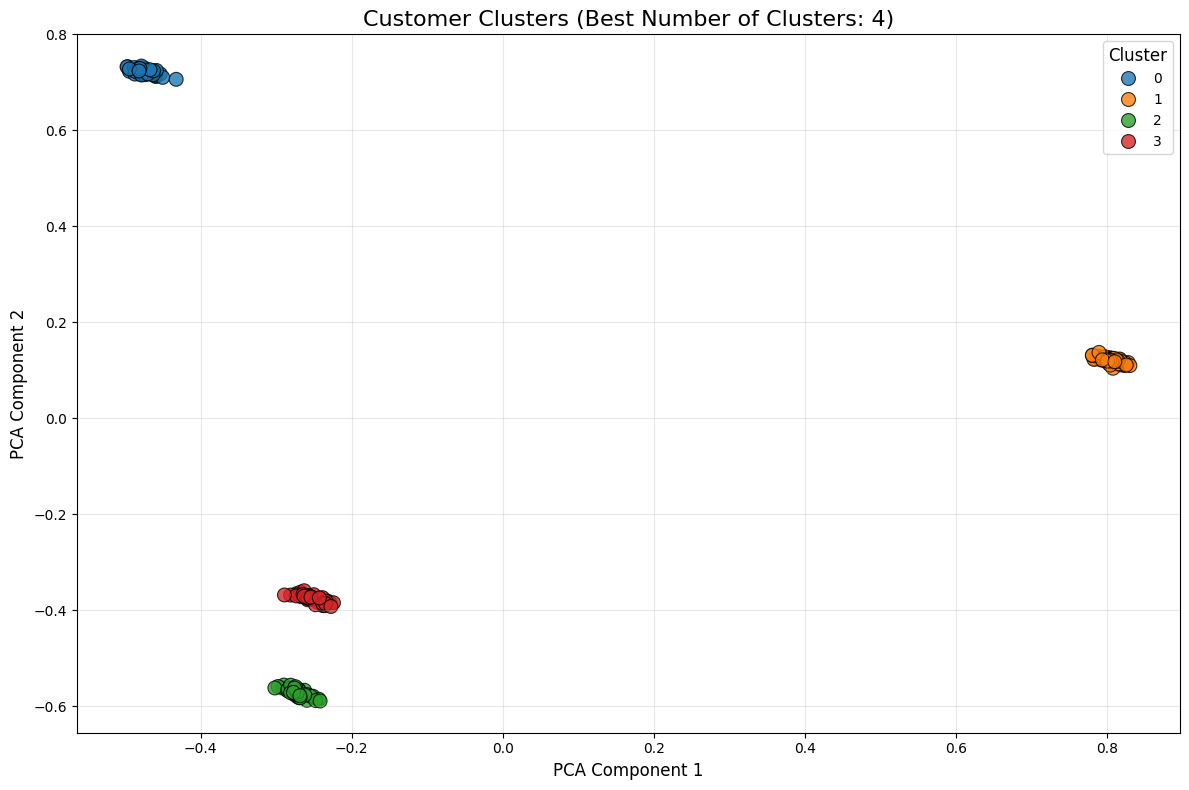


Best Clustering Configuration:
Number of Clusters: 4
Davies-Bouldin Index: 0.3915
Silhouette Score: 0.7444
Inertia: 18.1855
Calinski-Harabasz Index: 537.3240


In [1]:
# Customer Segmentation / Clustering
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers_path = r"C:\Users\gaura\Downloads\Customers.xlsx"
transactions_path = r"C:\Users\gaura\Downloads\Transactions.xlsx"
customers_df = pd.read_excel(customers_path)
transactions_df = pd.read_excel(transactions_path)

# Feature engineering
customer_transactions = transactions_df.groupby("CustomerID").agg(
    total_spend=("TotalValue", "sum"),
    purchase_frequency=("TransactionID", "count"),
    avg_quantity=("Quantity", "mean"),
).reset_index()

# Merge data
customer_features = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left")
customer_features.fillna(0, inplace=True)

# One-hot encode categorical data
customer_features = pd.get_dummies(customer_features, columns=["Region"], prefix="region")

# Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ["total_spend", "purchase_frequency", "avg_quantity"]
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Select features for clustering
excluded_cols = ["CustomerID", "SignupDate", "CustomerName"]  # Exclude non-numeric and irrelevant columns
feature_cols = [col for col in customer_features.columns if col not in excluded_cols]
X = customer_features[feature_cols]

# Clustering evaluation
cluster_results = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    # Compute metrics
    db_index = davies_bouldin_score(X, labels)
    silhouette_avg = silhouette_score(X, labels)
    inertia = kmeans.inertia_
    calinski_harabasz = calinski_harabasz_score(X, labels)

    cluster_results[n_clusters] = {
        "DB_Index": db_index,
        "Silhouette_Score": silhouette_avg,
        "Inertia": inertia,
        "Calinski_Harabasz": calinski_harabasz,
        "Labels": labels
    }

    # Print clustering metrics
    print(f"\nNumber of Clusters: {n_clusters}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    print(f"Inertia: {inertia:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

# Find the best number of clusters
best_n_clusters = min(cluster_results, key=lambda k: cluster_results[k]["DB_Index"])
best_labels = cluster_results[best_n_clusters]["Labels"]

# Add cluster labels to the dataframe
customer_features["Cluster"] = best_labels

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
customer_features["PCA1"] = X_pca[:, 0]
customer_features["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=customer_features,
    palette="tab10", s=100, edgecolor="black", alpha=0.8
)
plt.title(f"Customer Clusters (Best Number of Clusters: {best_n_clusters})", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Cluster", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

# Print best clustering configuration
print("\nBest Clustering Configuration:")
print(f"Number of Clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index: {cluster_results[best_n_clusters]['DB_Index']:.4f}")
print(f"Silhouette Score: {cluster_results[best_n_clusters]['Silhouette_Score']:.4f}")
print(f"Inertia: {cluster_results[best_n_clusters]['Inertia']:.4f}")
print(f"Calinski-Harabasz Index: {cluster_results[best_n_clusters]['Calinski_Harabasz']:.4f}")